# Import Libraries

In [1]:
# --- Data Manipulation and Preprocessing ---
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- Machine Learning Models and Tools ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# --- Deep Learning Tools (TensorFlow/Keras) ---
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# --- Word Embedding ---
from gensim.models import Word2Vec

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Tải các gói dữ liệu cần thiết từ NLTK
nltk.download('wordnet')         # Tải WordNet cho lemmatization
nltk.download('stopwords')       # Tải stopwords để loại bỏ các từ không quan trọng

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
%%capture
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Data Loading and Preprocessing
## Load the IMDB Dataset

In [4]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Count and Visualize the Sentiment Column

In [6]:
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

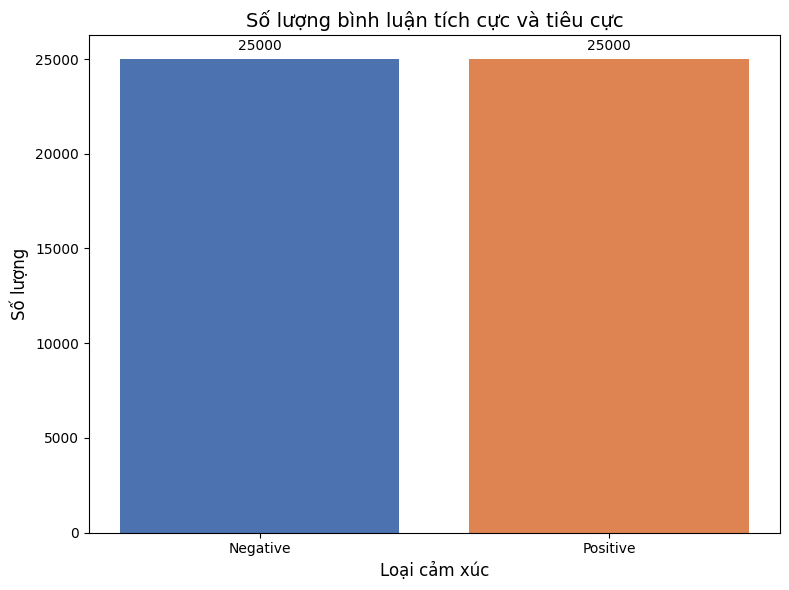

In [7]:
# Vẽ biểu đồ
colors = sns.color_palette('deep')
plt.figure(figsize=(8, 6), tight_layout=True)
plt.bar(['Negative', 'Positive'], sentiment_counts, color=colors[:2])
plt.title('Số lượng bình luận tích cực và tiêu cực', fontsize=14)
plt.xlabel('Loại cảm xúc', fontsize=12)
plt.ylabel('Số lượng', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Hiển thị giá trị cụ thể trên đầu các cột
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 500, str(count), ha='center', fontsize=10)

plt.show()

## Clean the Comments

In [8]:
# Hàm làm sạch văn bản
def clean_text(text):
    # Loại bỏ HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Loại bỏ URLs
    text = re.sub(r'http\S+', '', text)
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Chuyển về chữ thường
    text = text.lower().strip()
    # Loại bỏ stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Ghép lại thành câu
    text = ' '.join(words)
    return text

# Tạo cột mới 'cleaned_review' để lưu bình luận sau khi làm sạch
df['cleaned_review'] = df['review'].apply(clean_text)

# Chuyển đổi nhãn cảm xúc thành dạng số: positive -> 1, negative -> 0
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x.strip() == 'positive' else 0)

In [9]:
# Kiểm tra tỷ lệ ban đầu của nhãn
print("\nTỷ lệ ban đầu của nhãn cảm xúc:")
print(df['sentiment'].value_counts())

# Hiển thị mẫu dữ liệu với cột mới
print("\nDữ liệu sau khi thêm cột 'cleaned_review':")
print(df[['review', 'cleaned_review', 'sentiment']].head(10))


Tỷ lệ ban đầu của nhãn cảm xúc:
sentiment
1    25000
0    25000
Name: count, dtype: int64

Dữ liệu sau khi thêm cột 'cleaned_review':
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   
5  Probably my all-time favorite movie, a story o...   
6  I sure would like to see a resurrection of a u...   
7  This show was an amazing, fresh & innovative i...   
8  Encouraged by the positive comments about this...   
9  If you like original gut wrenching laughter yo...   

                                      cleaned_review  sentiment  
0  one reviewer mentioned watching oz episode you...          1  
1  wonderful little production filming technique ...          1  
2  thought wonderful way spend time hot summer we.

## Split the Data into Train and Test Sets

In [10]:
# Chia dữ liệu thành tập huấn luyện và kiểm thử (80:20) với tỷ lệ nhãn cân bằng
X = df['cleaned_review']  # Sử dụng cột đã làm sạch cho mô hình
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Kiểm tra tỷ lệ nhãn trong tập huấn luyện và tập kiểm thử
print("\nTỷ lệ nhãn trong tập huấn luyện:")
print(y_train.value_counts())
print("\nTỷ lệ nhãn trong tập kiểm thử:")
print(y_test.value_counts())


Tỷ lệ nhãn trong tập huấn luyện:
sentiment
1    20000
0    20000
Name: count, dtype: int64

Tỷ lệ nhãn trong tập kiểm thử:
sentiment
0    5000
1    5000
Name: count, dtype: int64


# Data Vectorization
## TF-IDF Vectorization

In [12]:
# Khởi tạo Vectorizer TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Vector hóa tập huấn luyện và kiểm thử
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF Vectorization hoàn tất.")
print(f"Shape của X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape của X_test_tfidf: {X_test_tfidf.shape}")

TF-IDF Vectorization hoàn tất.
Shape của X_train_tfidf: (40000, 5000)
Shape của X_test_tfidf: (10000, 5000)


## Word2Vec Embedding

In [13]:
# Tokenize dữ liệu huấn luyện để huấn luyện Word2Vec
tokens = [sentence.split() for sentence in X_train]

# Huấn luyện mô hình Word2Vec
word2vec_model = Word2Vec(sentences=tokens, vector_size=300, window=5, min_count=1, workers=4)
print("Huấn luyện mô hình Word2Vec hoàn tất.")


# Hàm chuyển văn bản thành vector trung bình của các từ
def text_to_vector(text, model):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in text.split():
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count > 0:
        return vector / count
    else:
        return vector


# Chuyển đổi văn bản thành vector trung bình
X_train_w2v = np.array([text_to_vector(text, word2vec_model) for text in X_train])
X_test_w2v = np.array([text_to_vector(text, word2vec_model) for text in X_test])

print("Word2Vec Embedding Vectorization hoàn tất.")
print(f"Shape của X_train_w2v: {X_train_w2v.shape}")
print(f"Shape của X_test_w2v: {X_test_w2v.shape}")

Huấn luyện mô hình Word2Vec hoàn tất.
Word2Vec Embedding Vectorization hoàn tất.
Shape của X_train_w2v: (40000, 300)
Shape của X_test_w2v: (10000, 300)


# Train Machine Learning Models

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Huấn luyện mô hình, tính accuracy trên tập train và test,
    và hiển thị confusion matrix trên tập test.

    Args:
        model: Mô hình cần huấn luyện.
        X_train: Dữ liệu huấn luyện (đặc trưng).
        y_train: Nhãn dữ liệu huấn luyện.
        X_test: Dữ liệu kiểm thử (đặc trưng).
        y_test: Nhãn dữ liệu kiểm thử.
        model_name: Tên của mô hình (str).

    Returns:
        model_name (str): Tên của mô hình.
        test_accuracy (float): Accuracy trên tập test (dạng %).
    """
    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên tập train và test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Tính độ chính xác (%)
    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100

    # In độ chính xác
    print(f"{model_name}")
    print(f"Độ chính xác trên tập huấn luyện: {train_accuracy:.2f}%")
    print(f"Độ chính xác trên tập kiểm thử: {test_accuracy:.2f}%")

    # Tính và vẽ confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - {model_name}")
    plt.show()

    # Trả về tên mô hình và độ chính xác trên tập test
    return model_name, test_accuracy

In [15]:
# Tạo dictionary để lưu kết quả
results = {}

## Logistic Regression

Logistic Regression (TF-IDF)
Độ chính xác trên tập huấn luyện: 90.96%
Độ chính xác trên tập kiểm thử: 88.60%


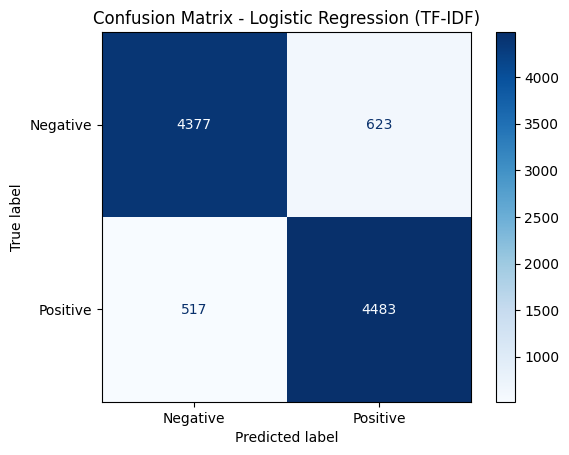

Logistic Regression (Word2Vec)
Độ chính xác trên tập huấn luyện: 86.25%
Độ chính xác trên tập kiểm thử: 86.09%


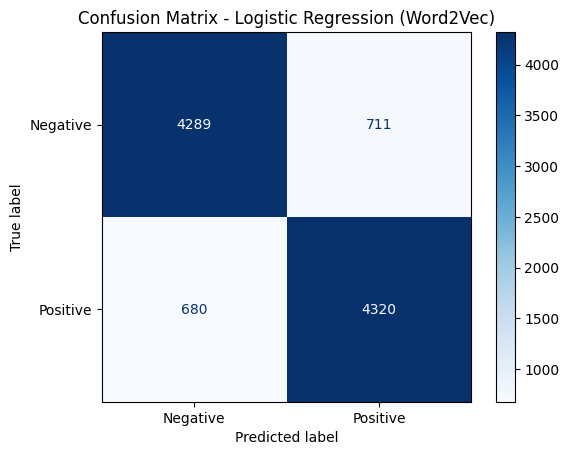

In [16]:
# Logistic Regression với TF-IDF
lr_tfidf = LogisticRegression(max_iter=500, random_state=42)
name, accuracy = evaluate_model(lr_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, "Logistic Regression (TF-IDF)")
results[name] = accuracy

# Logistic Regression với Word2Vec
lr_w2v = LogisticRegression(max_iter=500, random_state=42)
name, accuracy = evaluate_model(lr_w2v, X_train_w2v, y_train, X_test_w2v, y_test, "Logistic Regression (Word2Vec)")
results[name] = accuracy

## Support Vector Machine

SVM (TF-IDF)
Độ chính xác trên tập huấn luyện: 88.67%
Độ chính xác trên tập kiểm thử: 88.26%


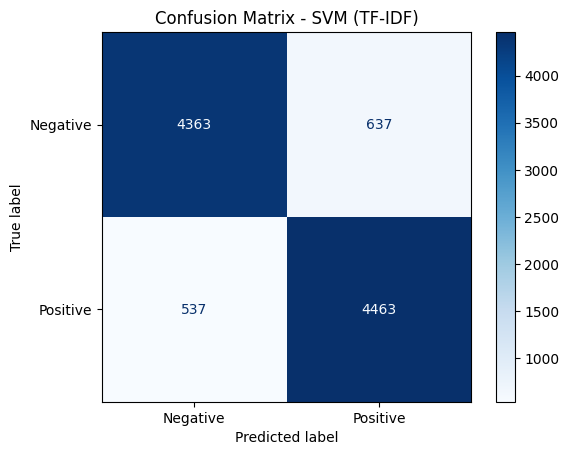

SVM (Word2Vec)
Độ chính xác trên tập huấn luyện: 68.29%
Độ chính xác trên tập kiểm thử: 69.57%


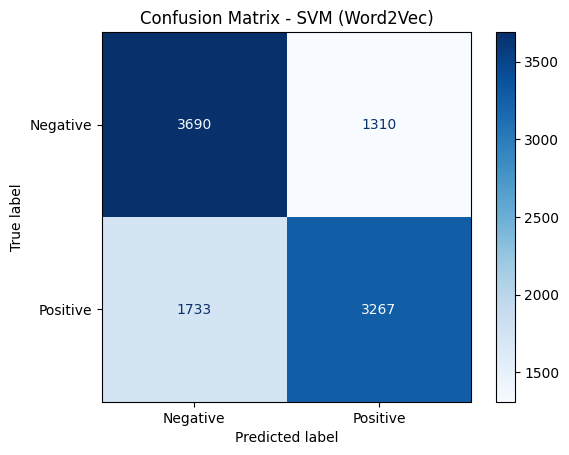

In [17]:
# Support Vector Machine với TF-IDF
svm_tfidf = SVC(kernel='sigmoid', random_state=42)
name, accuracy = evaluate_model(svm_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, "SVM (TF-IDF)")
results[name] = accuracy

# Support Vector Machine với Word2Vec
svm_w2v = SVC(kernel='sigmoid', random_state=42)
name, accuracy = evaluate_model(svm_w2v, X_train_w2v, y_train, X_test_w2v, y_test, "SVM (Word2Vec)")
results[name] = accuracy

## Naive Bayes

Naive Bayes (TF-IDF)
Độ chính xác trên tập huấn luyện: 86.07%
Độ chính xác trên tập kiểm thử: 85.31%


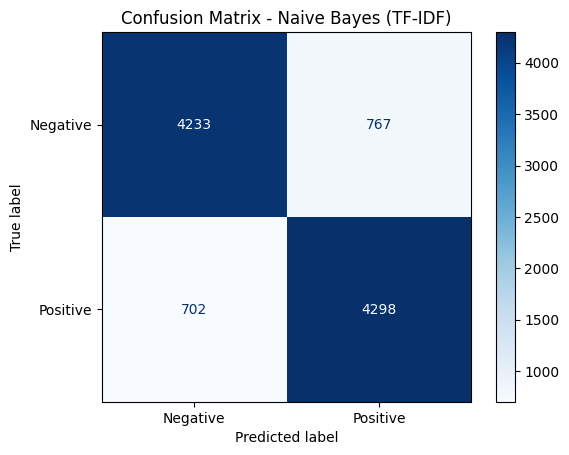

Naive Bayes với Word2Vec Gặp lỗi: Negative values in data passed to MultinomialNB (input X)
Naive Bayes không thể hoạt động tốt với vector embeddings trực tiếp.


In [18]:
# Naive Bayes với TF-IDF
nb_tfidf = MultinomialNB()
name, accuracy = evaluate_model(nb_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, "Naive Bayes (TF-IDF)")
results[name] = accuracy

# Naive Bayes không hoạt động tốt với dữ liệu embedding vector trực tiếp
# Thử huấn luyện nhưng có thể gặp lỗi
nb_w2v = MultinomialNB()
try:
    name, accuracy = evaluate_model(nb_w2v, X_train_w2v, y_train, X_test_w2v, y_test, 'Naive Bayes với Word2Vec')
    results[name] = accuracy
except Exception as e:
    print(f"Naive Bayes với Word2Vec Gặp lỗi: {e}")
    print("Naive Bayes không thể hoạt động tốt với vector embeddings trực tiếp.")
    results['Naive Bayes với Word2Vec'] = 0

## Random Forest

Random Forest (TF-IDF)
Độ chính xác trên tập huấn luyện: 100.00%
Độ chính xác trên tập kiểm thử: 84.86%


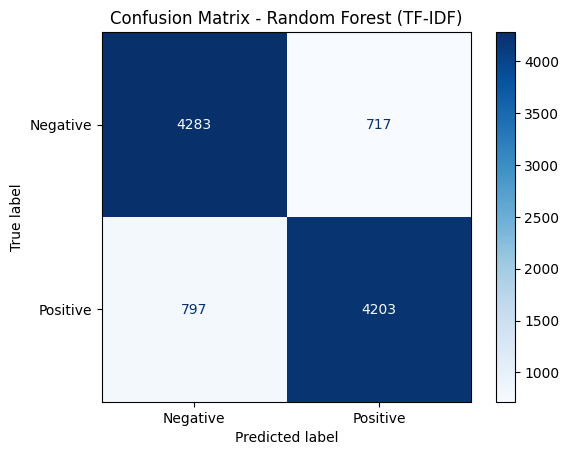

Random Forest (Word2Vec)
Độ chính xác trên tập huấn luyện: 100.00%
Độ chính xác trên tập kiểm thử: 83.76%


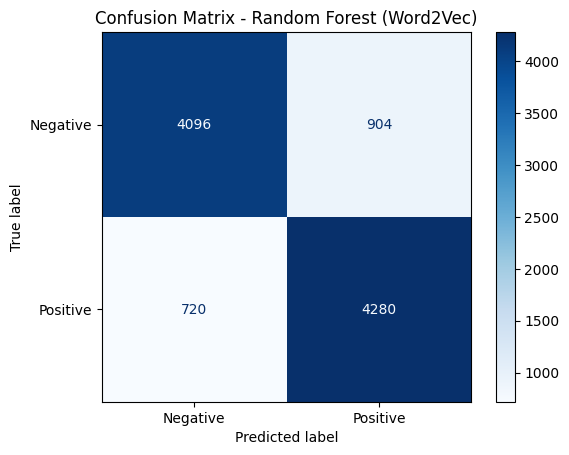

In [19]:
# Random Forest với TF-IDF
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42)
name, accuracy = evaluate_model(rf_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, "Random Forest (TF-IDF)")
results[name] = accuracy

# Random Forest với Word2Vec
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
name, accuracy = evaluate_model(rf_w2v, X_train_w2v, y_train, X_test_w2v, y_test, "Random Forest (Word2Vec)")
results[name] = accuracy

## AdaBoost

AdaBoost (TF-IDF)
Độ chính xác trên tập huấn luyện: 67.36%
Độ chính xác trên tập kiểm thử: 67.59%


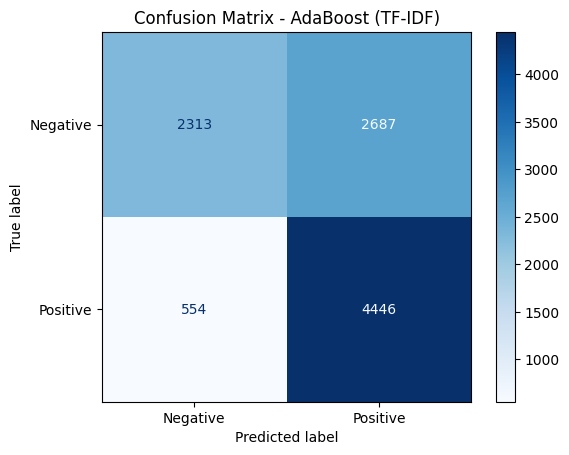

AdaBoost (Word2Vec)
Độ chính xác trên tập huấn luyện: 76.04%
Độ chính xác trên tập kiểm thử: 75.84%


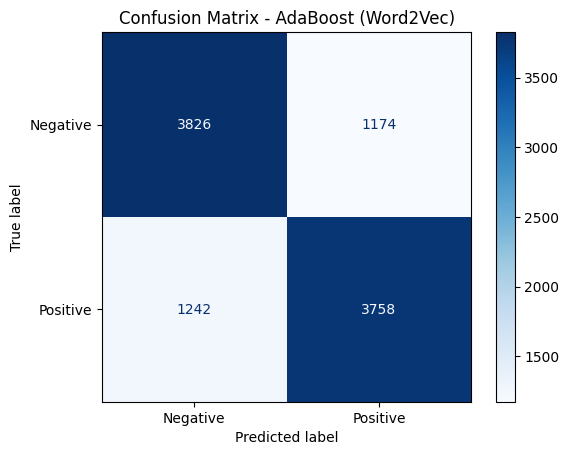

In [20]:
# AdaBoost với TF-IDF
ab_tfidf = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=42)
name, accuracy = evaluate_model(ab_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, "AdaBoost (TF-IDF)")
results[name] = accuracy

# AdaBoost với Word2Vec
ab_w2v = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=42)
name, accuracy = evaluate_model(ab_w2v, X_train_w2v, y_train, X_test_w2v, y_test, "AdaBoost (Word2Vec)")
results[name] = accuracy

In [21]:
# Hiển thị kết quả
print("\nKết quả mô hình:")
for model_name, test_accuracy in results.items():
    print(f"{model_name}: {test_accuracy:.2f}%")


Kết quả mô hình:
Logistic Regression (TF-IDF): 88.60%
Logistic Regression (Word2Vec): 86.09%
SVM (TF-IDF): 88.26%
SVM (Word2Vec): 69.57%
Naive Bayes (TF-IDF): 85.31%
Naive Bayes với Word2Vec: 0.00%
Random Forest (TF-IDF): 84.86%
Random Forest (Word2Vec): 83.76%
AdaBoost (TF-IDF): 67.59%
AdaBoost (Word2Vec): 75.84%


# Deep Learning Model (LSTM)
## Tokenization and Padding

In [22]:
# Thiết lập các tham số cho Tokenizer và Padding
max_len = 1000  # Độ dài tối đa của chuỗi
max_features = 5000  # Số từ vựng tối đa

# Khởi tạo Tokenizer
tokenizer = Tokenizer(num_words=max_features, oov_token='<unk>')
tokenizer.fit_on_texts(X_train)

# Chuyển đổi văn bản thành chuỗi các số nguyên
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding các chuỗi để có độ dài bằng nhau
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Tokenization và Padding hoàn tất.")
print(f"Shape của X_train_pad: {X_train_pad.shape}")
print(f"Shape của X_test_pad: {X_test_pad.shape}")

Tokenization và Padding hoàn tất.
Shape của X_train_pad: (40000, 1000)
Shape của X_test_pad: (10000, 1000)


## Build LSTM Model

In [23]:
# Thiết lập các tham số cho Embedding
embedding_dim = 300

# Tạo ma trận embedding từ Word2Vec
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_features and word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_features,
                         output_dim=embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_len,
                         trainable=True))
model_lstm.add(LSTM(300, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile mô hình
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

print("Mô hình LSTM đã được xây dựng và compile.")

# Thiết lập ModelCheckpoint để lưu lại mô hình tốt nhất dựa trên validation loss
checkpoint = ModelCheckpoint('best_model_lstm.keras', 
                             monitor='val_loss', 
                             mode='min', 
                             save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Mô hình LSTM đã được xây dựng và compile.


## Train LSTM Model

In [24]:
%%time
# Huấn luyện mô hình
history_lstm = model_lstm.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                              epochs=30,
                              batch_size=512,
                              callbacks=[checkpoint],
                              verbose=2)

Epoch 1/30
79/79 - 56s - 711ms/step - accuracy: 0.8151 - loss: 0.3946 - val_accuracy: 0.8664 - val_loss: 0.3462
Epoch 2/30
79/79 - 51s - 644ms/step - accuracy: 0.8850 - loss: 0.2773 - val_accuracy: 0.8924 - val_loss: 0.3140
Epoch 3/30
79/79 - 52s - 652ms/step - accuracy: 0.9044 - loss: 0.2375 - val_accuracy: 0.8952 - val_loss: 0.3039
Epoch 4/30
79/79 - 51s - 651ms/step - accuracy: 0.9220 - loss: 0.1996 - val_accuracy: 0.8966 - val_loss: 0.2731
Epoch 5/30
79/79 - 51s - 649ms/step - accuracy: 0.9307 - loss: 0.1811 - val_accuracy: 0.8999 - val_loss: 0.2666
Epoch 6/30
79/79 - 51s - 651ms/step - accuracy: 0.9439 - loss: 0.1503 - val_accuracy: 0.8978 - val_loss: 0.2664
Epoch 7/30
79/79 - 51s - 648ms/step - accuracy: 0.9551 - loss: 0.1236 - val_accuracy: 0.8978 - val_loss: 0.2553
Epoch 8/30
79/79 - 51s - 646ms/step - accuracy: 0.9674 - loss: 0.0965 - val_accuracy: 0.8858 - val_loss: 0.2711
Epoch 9/30
79/79 - 51s - 651ms/step - accuracy: 0.9758 - loss: 0.0736 - val_accuracy: 0.8889 - val_loss:

## Plot the Training Process

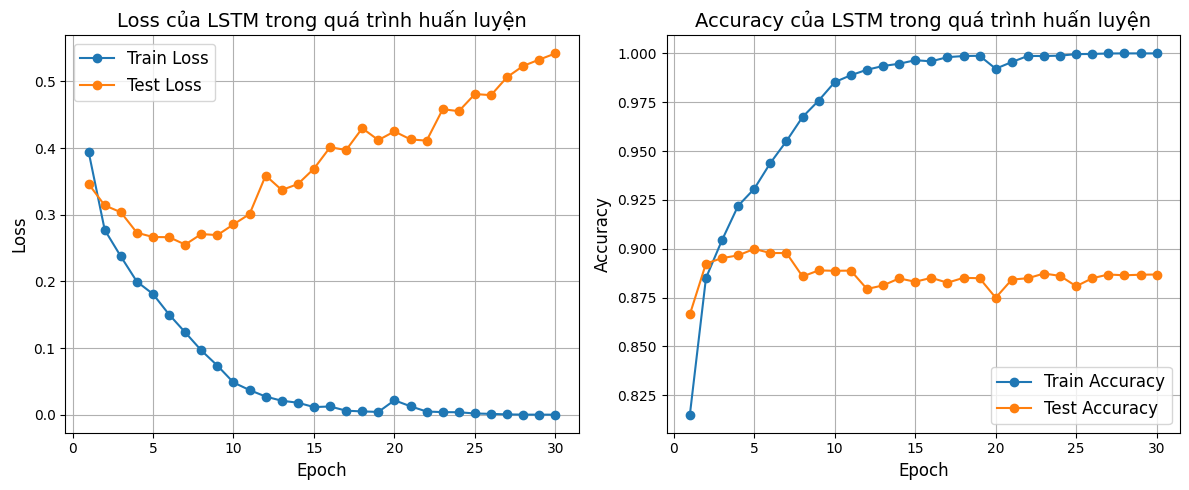

In [25]:
# Vẽ biểu đồ Loss và Accuracy của LSTM trong quá trình huấn luyện
def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)  # Số epoch

    # Vẽ Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], '-o', label='Train Loss')  # Thêm '-o' để biểu thị điểm
    plt.plot(epochs, history.history['val_loss'], '-o', label='Test Loss')  # Thêm '-o'
    plt.title('Loss của LSTM trong quá trình huấn luyện', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Vẽ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], '-o', label='Train Accuracy')  # Thêm '-o'
    plt.plot(epochs, history.history['val_accuracy'], '-o', label='Test Accuracy')  # Thêm '-o'
    plt.title('Accuracy của LSTM trong quá trình huấn luyện', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Tối ưu bố cục hiển thị
    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ lịch sử huấn luyện
plot_history(history_lstm)

## Evaluate the Best LSTM Model

In [26]:
# Load mô hình tốt nhất đã được lưu
from tensorflow.keras.models import load_model
best_model = load_model('/kaggle/working/best_model_lstm.keras')

In [27]:
# Đánh giá mô hình trên tập kiểm thử
loss_lstm, accuracy_lstm = best_model.evaluate(X_test_pad, y_test, batch_size=512)
accuracy_lstm_percent = accuracy_lstm * 100
print(f"LSTM Model Test Loss: {loss_lstm:.4f}, Test Accuracy: {accuracy_lstm_percent:.2f}%")

# Thêm kết quả vào dictionary
results["LSTM"] = accuracy_lstm_percent

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.8955 - loss: 0.2570
LSTM Model Test Loss: 0.2553, Test Accuracy: 89.78%


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step


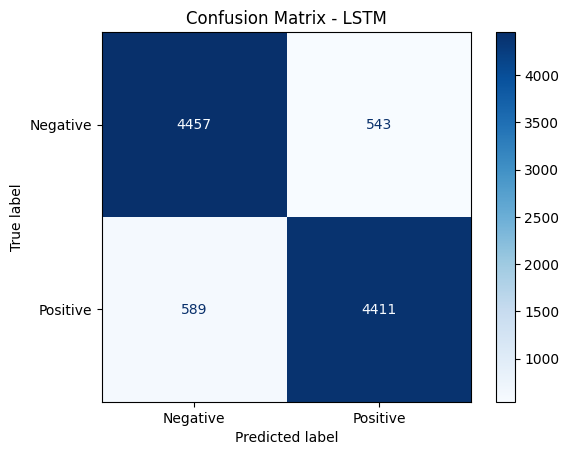

In [28]:
# Vẽ confusion matrix
y_test_pred = (model_lstm.predict(X_test_pad, batch_size=512) > 0.5).astype("int32").flatten()
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
disp.ax_.set_title("Confusion Matrix - LSTM")
plt.show()

# Conclusion


Bảng So sánh Kết quả Các Mô hình:
                             Model  Accuracy (%)
10                            LSTM     89.780003
0     Logistic Regression (TF-IDF)     88.600000
2                     SVM (TF-IDF)     88.260000
1   Logistic Regression (Word2Vec)     86.090000
4             Naive Bayes (TF-IDF)     85.310000
6           Random Forest (TF-IDF)     84.860000
7         Random Forest (Word2Vec)     83.760000
9              AdaBoost (Word2Vec)     75.840000
3                   SVM (Word2Vec)     69.570000
8                AdaBoost (TF-IDF)     67.590000
5         Naive Bayes với Word2Vec      0.000000


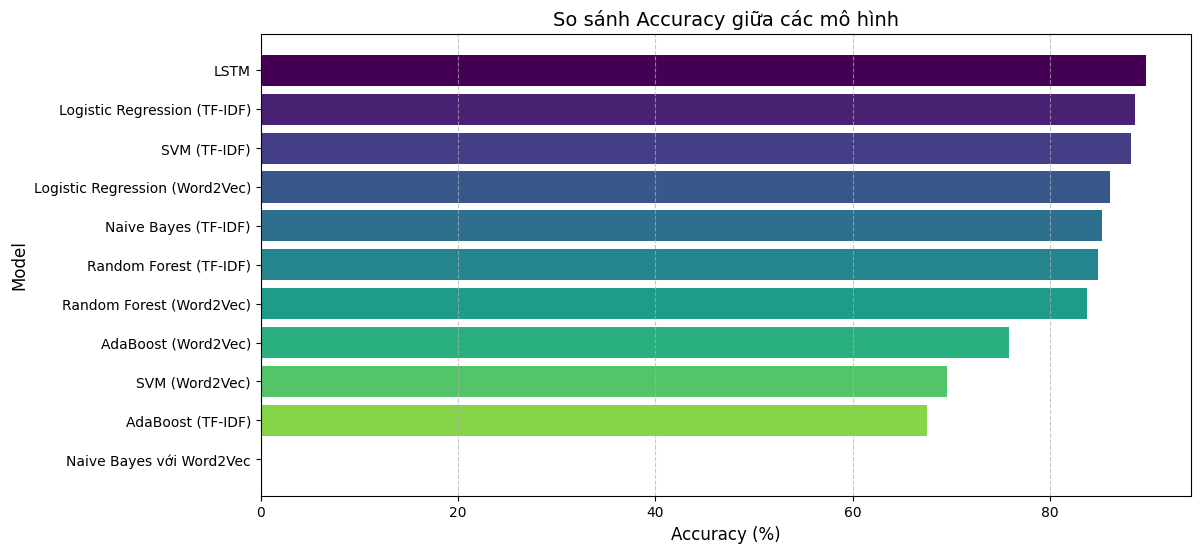

In [29]:
# Tạo DataFrame từ dictionary kết quả
results_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy (%)': [accuracy if accuracy is not None else 0 for accuracy in results.values()]
})

# Sắp xếp các mô hình theo độ chính xác giảm dần
results_df = results_df.sort_values(by='Accuracy (%)', ascending=False)

# Hiển thị bảng kết quả
print("\nBảng So sánh Kết quả Các Mô hình:")
print(results_df)

# Chọn bảng màu
palette = plt.colormaps["viridis"]
colors = [palette(i / len(results_df)) for i in range(len(results_df))]

# Vẽ biểu đồ cột ngang với màu sắc khác nhau
plt.figure(figsize=(12, 6))
plt.barh(results_df['Model'], results_df['Accuracy (%)'], color=colors)
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('So sánh Accuracy giữa các mô hình', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()